<a href="https://colab.research.google.com/github/chrishendra93/MI_Workshop/blob/main/Mnist_Multiple_Instance_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(0)

In [ ]:
root_dir = "/content/drive/MyDrive/Journal Club MIL/mnist_clr"

mnist_columns = ["label"] + ["features_{}".format(i) for i in range(28 ** 2)]
mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv", names=mnist_columns)
mnist_test = pd.read_csv("./sample_data/mnist_test.csv", names=mnist_columns)
mnist_arr_train = mnist_train[["features_{}".format(i) for i in range(28 ** 2)]].values
mnist_arr_test = mnist_test[["features_{}".format(i) for i in range(28 ** 2)]].values

X_train = np.load(os.path.join(root_dir, "train_features.npy"))
X_test = np.load(os.path.join(root_dir, "test_features.npy"))
y_train = np.load(os.path.join(root_dir, "train_labels.npy"))
y_test = np.load(os.path.join(root_dir, "test_labels.npy"))

print(np.all(y_train == mnist_train["label"].values))
print(np.all(y_test == mnist_test["label"].values))



FileNotFoundError: ignored

In [ ]:
mnist_train.head()

,label,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,features_10,features_11,features_12,features_13,features_14,features_15,features_16,features_17,features_18,features_19,features_20,features_21,features_22,features_23,features_24,features_25,features_26,features_27,features_28,features_29,features_30,features_31,features_32,features_33,features_34,features_35,features_36,features_37,features_38,...,features_744,features_745,features_746,features_747,features_748,features_749,features_750,features_751,features_752,features_753,features_754,features_755,features_756,features_757,features_758,features_759,features_760,features_761,features_762,features_763,features_764,features_765,features_766,features_767,features_768,features_769,features_770,features_771,features_772,features_773,features_774,features_775,features_776,features_777,features_778,features_779,features_780,features_781,features_782,features_783
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that our features are aligned, let's visualize some images

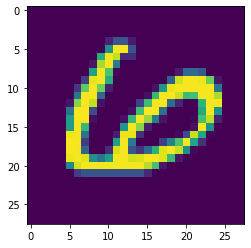

In [ ]:
plt.imshow(mnist_arr_train[0].reshape(28, 28))

In [ ]:
import copy

def create_bags(mnist_df):
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bags = []
    i = 0
    all_indices, all_labels = np.arange(len(mnist_df)), mnist_df["label"].values
    np.random.shuffle(all_indices)
    all_labels = all_labels[all_indices]
    while i < len(mnist_df):
      bag_size = np.random.randint(3, 7)
      indices = all_indices[i: i + bag_size]
      labels = all_labels[i: i + bag_size]
      bag_label = get_bag_label(labels)
      bags.append((indices, bag_label))
      i += bag_size
    return bags

def get_bag_label(instance_labels):
  return np.any(instance_labels == 9) * 1

def fetch_images(indices, mnist_arr):
  return mnist_arr[indices]

In [ ]:
train_bags = create_bags(mnist_train)
test_bags = create_bags(mnist_test)

train_labels = np.array([bag[-1] for bag in train_bags])
test_labels = np.array([bag[-1] for bag in test_bags])

(array([1404.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         826.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

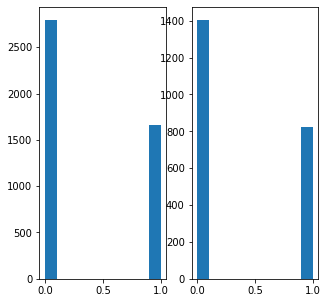

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_labels)
axes[1].hist(test_labels)


Distribution of labels seems to be equal between the two bags, let's check the distribution of instances

(array([564.,   0.,   0., 594.,   0.,   0., 500.,   0.,   0., 572.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 10 Patch objects>)

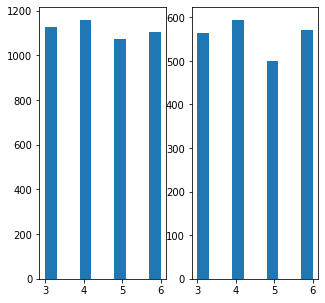

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist([len(bag[0]) for bag in train_bags])
axes[1].hist([len(bag[0]) for bag in test_bags])


In [ ]:
print(len(train_bags))
print(len(test_bags))

4461
2230


Let's visualize some of these bag contents

In [ ]:
def visualize_bags(mnist_arr, bags, n_bags):
  sampled_indices = np.random.choice(len(bags), n_bags, replace=False)
  sampled_bags = np.array(bags)[sampled_indices]
  max_instances_num = np.max([len(bag[0]) for bag in sampled_bags])
  _, axes = plt.subplots(len(sampled_bags), max_instances_num,
                         figsize=(10 * len(sampled_bags), 
                                  10 * max_instances_num))
  for idx, bag in zip(np.arange(n_bags), sampled_bags):
    ax = axes[idx, :]
    bag_label = bag[-1]
    instance_size = None
    for i in range(max_instances_num):
      if i >= len(bag[0]):
        ax[i].imshow(np.zeros(instance_size)) # Pad with empty images if bag has fewer instances than max
      else:
        img = mnist_arr[bag[0][i]]
        if instance_size is None:
          w = int(np.sqrt(len(img)))
          instance_size = (w, w)
        ax[i].imshow(img.reshape(instance_size))
        if i == max_instances_num // 2:
          ax[i].set_title('Bag Label: {}'.format(bag_label), fontsize=50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


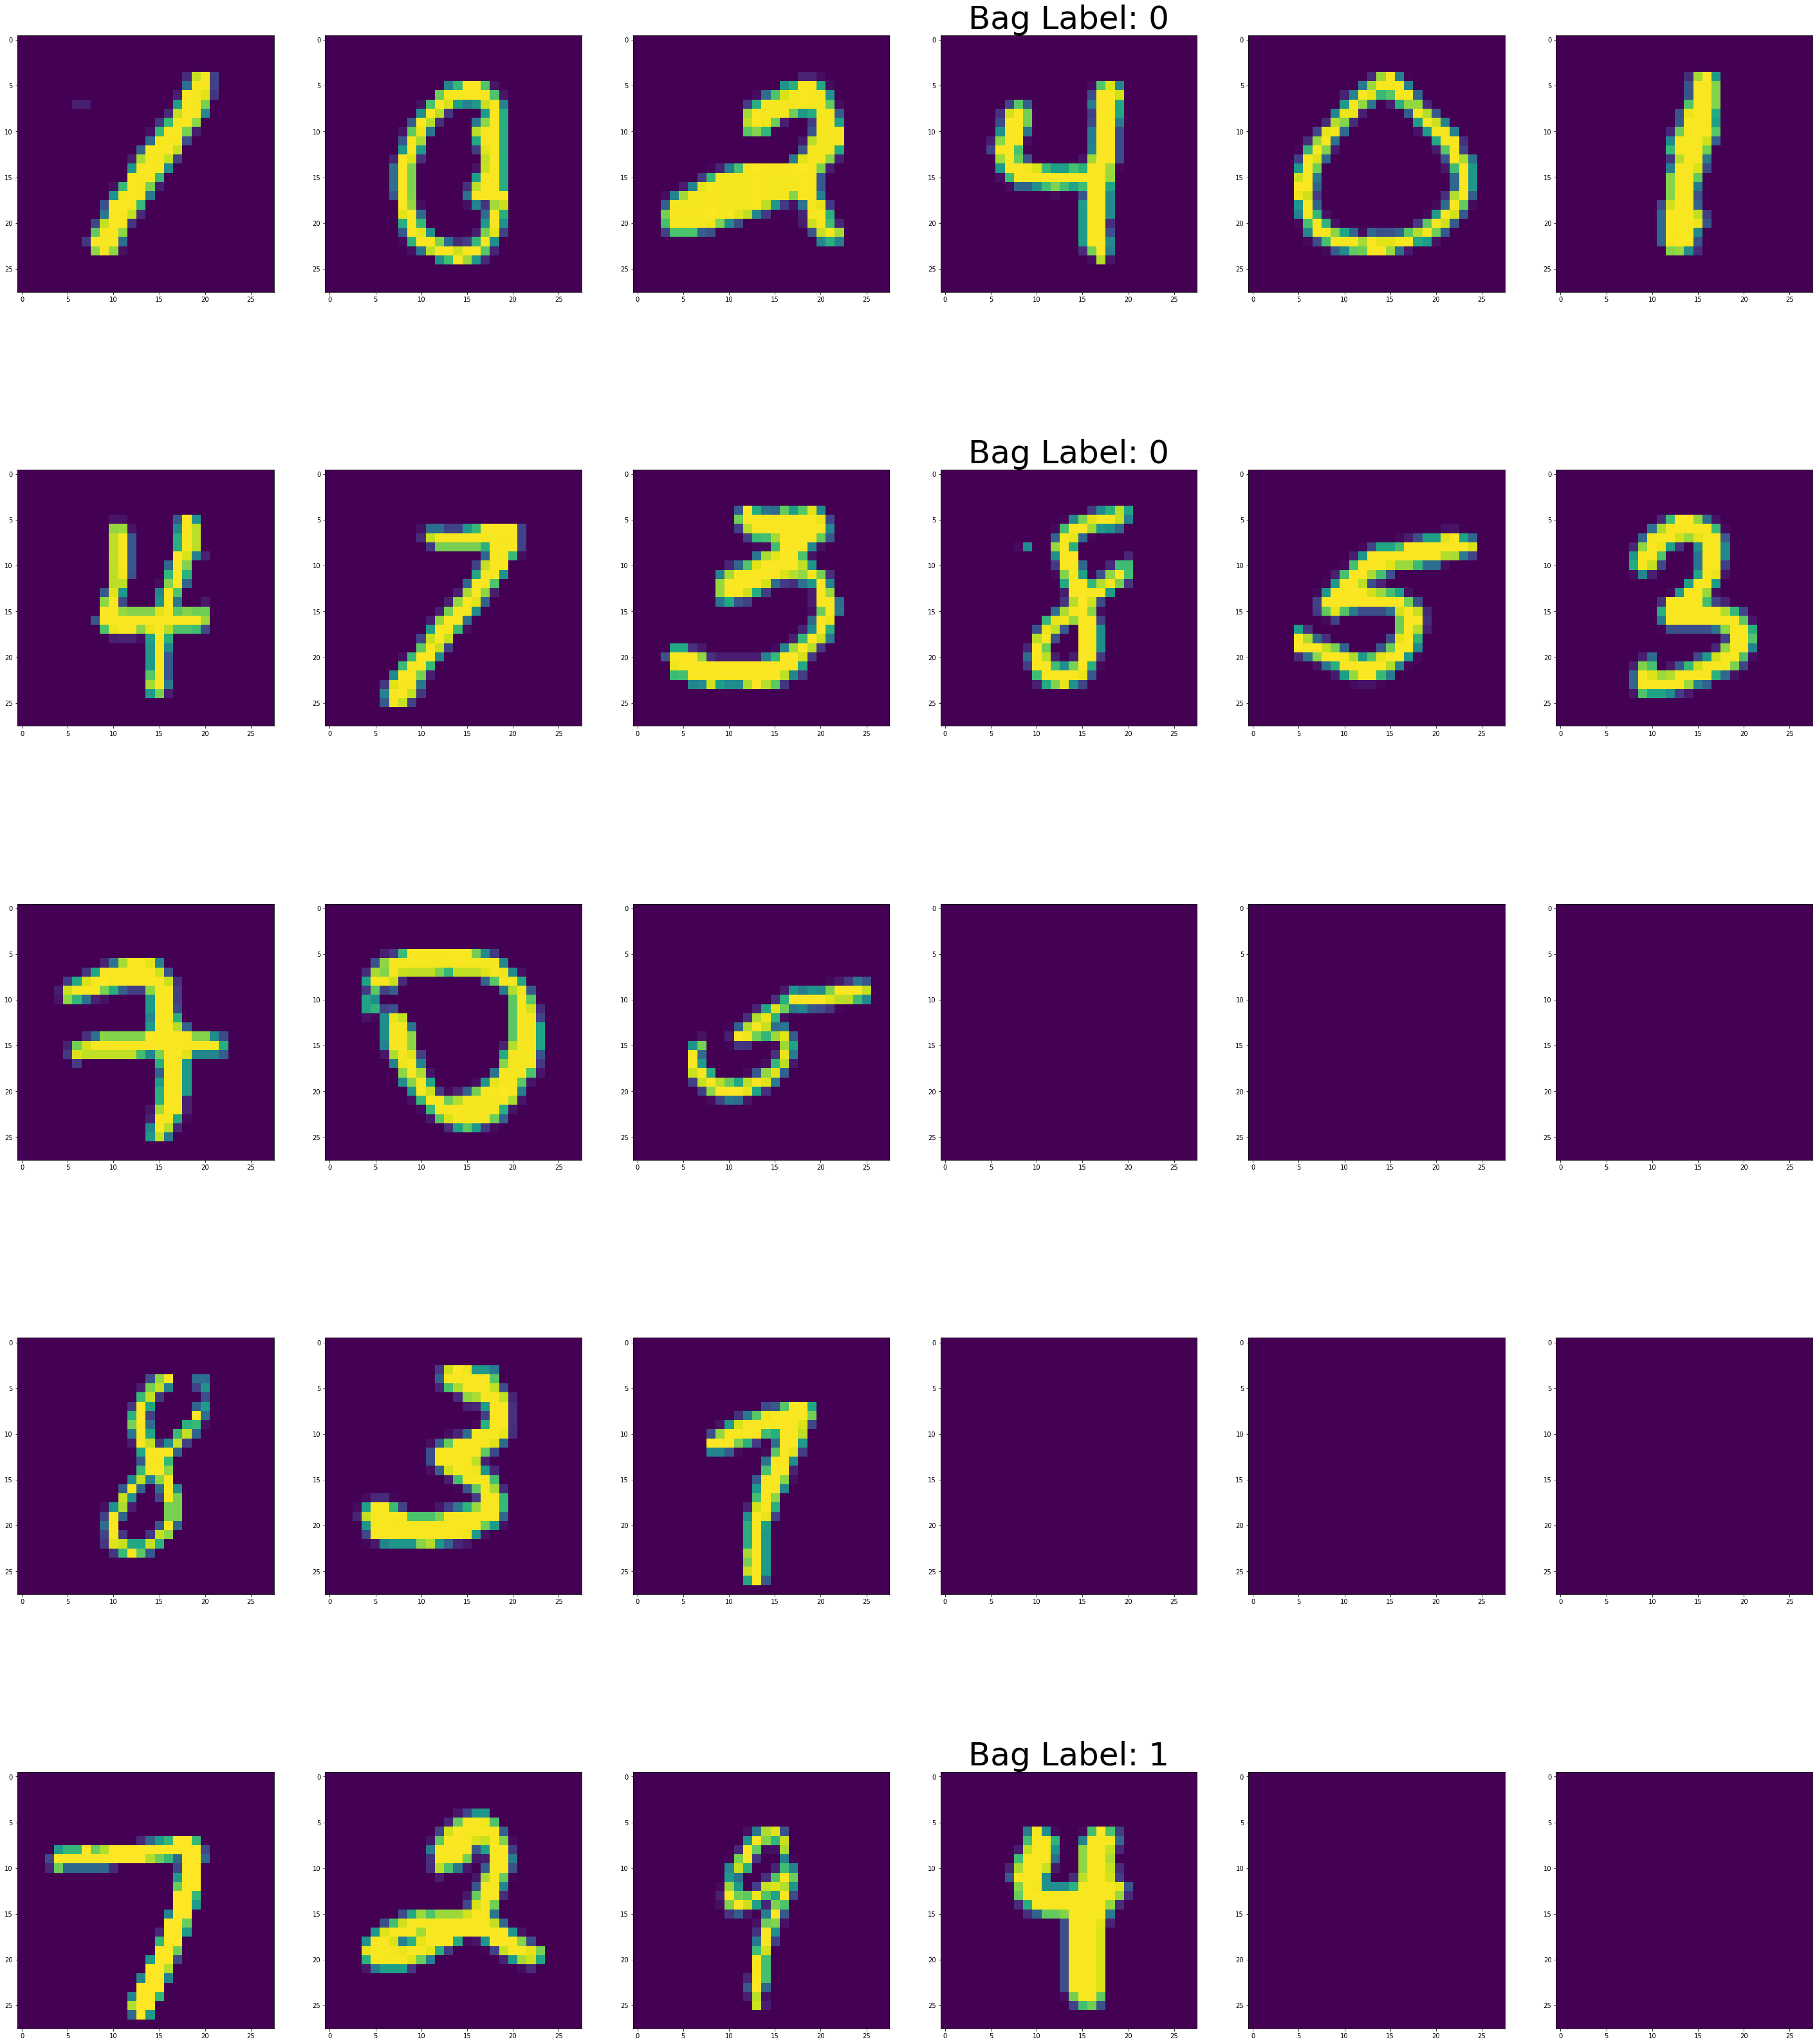

In [ ]:
visualize_bags(mnist_arr_train, train_bags, 5)

In [ ]:
def fetch_instances(mnist_features, indices):
  return mnist_features[indices]

def extract_summary_stats(mnist_features, bags):
  max_ = np.array([np.max(mnist_features[bag[0]]) for bag in bags])
  min_ = np.array([np.min(mnist_features[bag[0]]) for bag in bags])
  mean_ = np.array([np.mean(mnist_features[bag[0]]) for bag in bags])
  var_ = np.array([np.var(mnist_features[bag[0]]) for bag in bags])
  med_ = np.array([np.median(mnist_features[bag[0]]) for bag in bags])
  return np.concatenate([max_.reshape(-1, 1), 
                         min_.reshape(-1, 1), 
                         mean_.reshape(-1, 1), 
                         var_.reshape(-1, 1), 
                         med_.reshape(-1, 1)], axis=1)

In [ ]:
X_train_stats = extract_summary_stats(X_train, train_bags)
X_test_stats = extract_summary_stats(X_test, test_bags)

In [ ]:
print(X_train_stats.shape, train_labels.shape)
print(X_test_stats.shape, test_labels.shape)

(4461, 5) (4461,)
(2230, 5) (2230,)


In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train_stats)
pca_obj = PCA().fit(scaler.transform(X_train_stats))
X_train_pca = pca_obj.transform(scaler.transform(X_train_stats))
X_test_pca = pca_obj.transform(scaler.transform(X_test_stats))

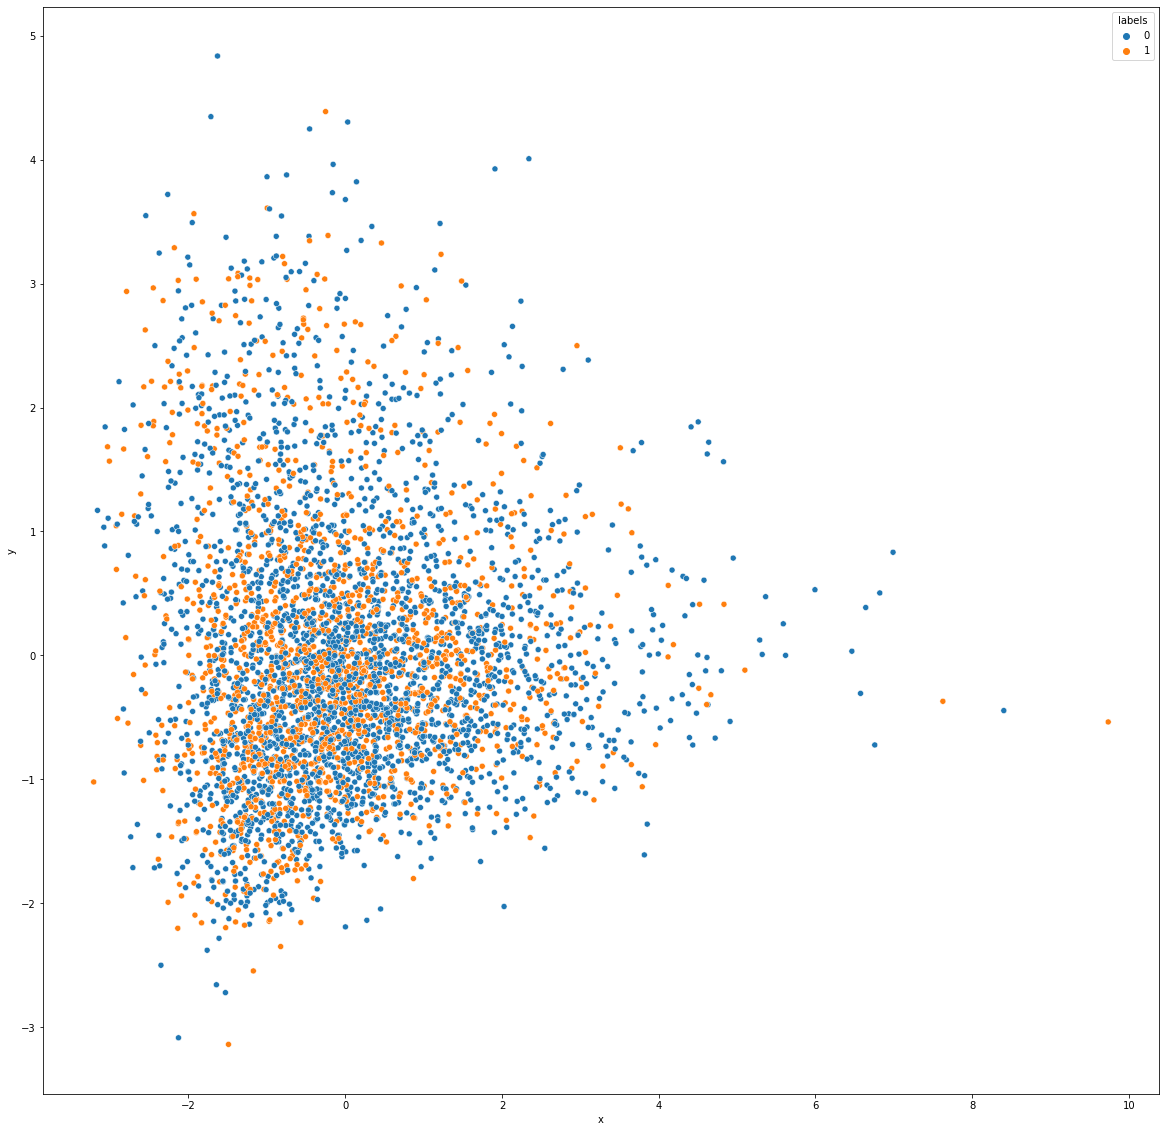

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_pca[:, 0].flatten(), 
                              'y': X_train_pca[:, 1].flatten(),
                              'labels': train_labels})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)

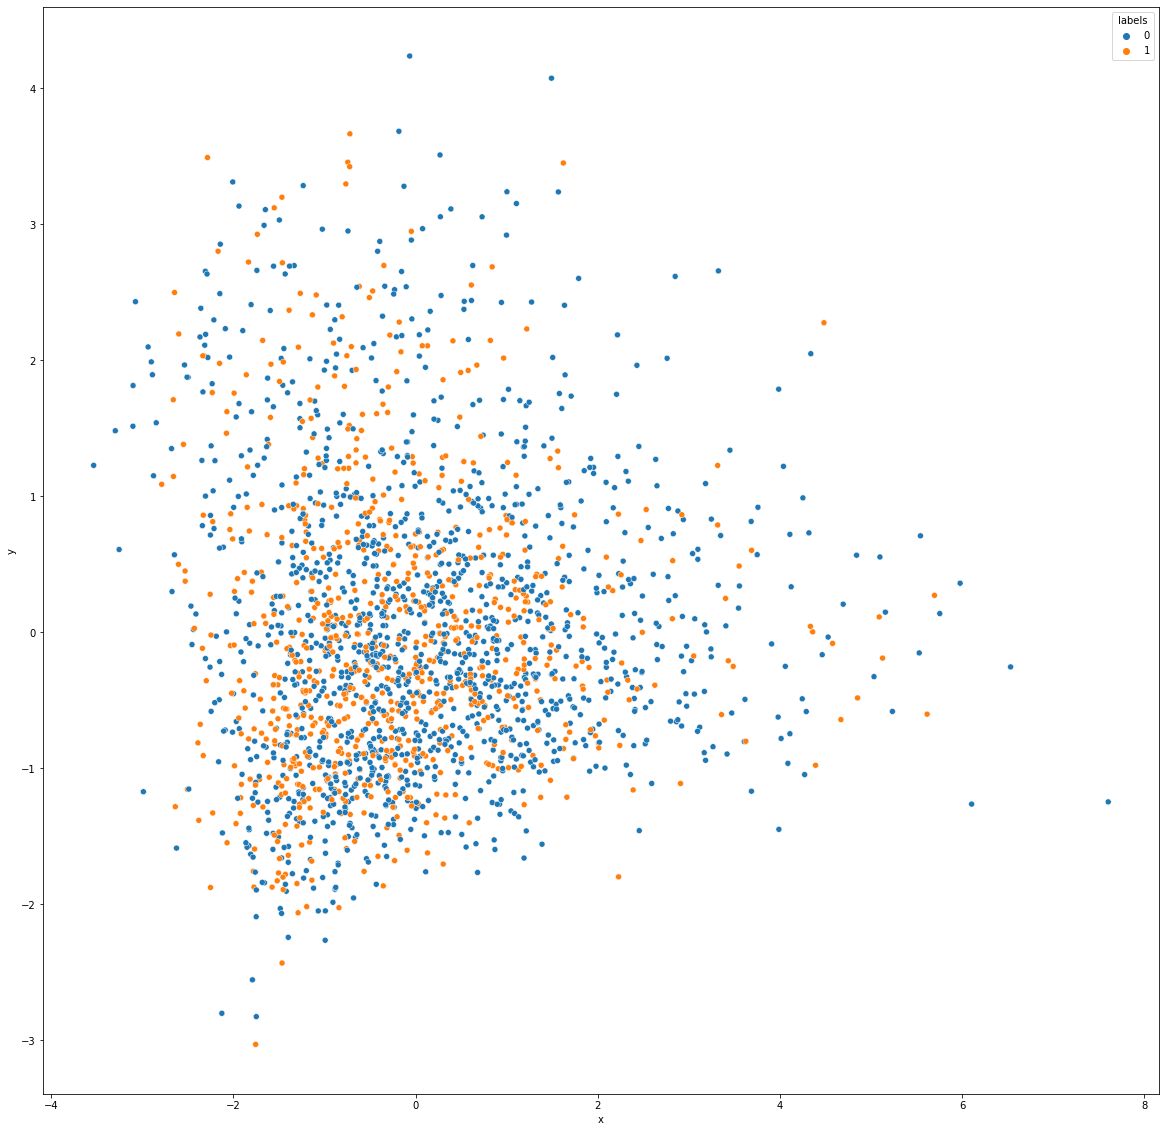

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_test = pd.DataFrame({'x': X_test_pca[:, 0].flatten(), 
                              'y': X_test_pca[:, 1].flatten(),
                              'labels': test_labels})
to_plot_test["labels"] = to_plot_test["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_test, hue='labels', ax=ax)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

In [ ]:
def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

In [ ]:
model = LogisticRegression(max_iter=10000).fit(X_train_stats, train_labels)
y_test_pred = model.predict(X_test_stats)
print(accuracy_score(test_labels, y_test_pred))
print(balanced_accuracy_score(test_labels, y_test_pred))

0.6295964125560538
0.5


Now, le us try to compute Hausdorff distance from the test samples to the train samples

In [ ]:
from sklearn.metrics import pairwise_distances
pairwise_distance = pairwise_distances(X_test, X_train)
print(pairwise_distance.shape)


(10000, 20000)


In [ ]:
all_bag_distances = []

for test_bag in tqdm(test_bags, total=len(test_bags)):
  test_bag_indices = test_bag[0]
  test_bag_instances = pairwise_distance[test_bag_indices]
  bag_distances = []
  for train_bag in train_bags:
    train_bag_indices = train_bag[0]
    test_train_distance = np.max(np.min(test_bag_instances[:, train_bag_indices], axis=1))
    train_test_distance = np.max(np.min(test_bag_instances[:, train_bag_indices].transpose(), axis=1))
    bag_distances.append(max(test_train_distance, train_test_distance))
  all_bag_distances.append(np.array(bag_distances).reshape(1, -1))
all_bag_distances = np.concatenate(all_bag_distances, axis=0)
all_bag_distances.shape

(2230, 4461)

In [ ]:
np.argsort(all_bag_distances, axis=1)[:, :10].shape

(2230, 10)

In [ ]:
y_pred_test_knn = mode(train_labels[np.argsort(all_bag_distances, axis=1)[:, :10]], axis=1)[0].flatten()
print(accuracy_score(test_labels, y_pred_test_knn))
print(balanced_accuracy_score(test_labels, y_pred_test_knn))

0.6968609865470852
0.6207032139235529


Can we do even better?

In [ ]:
import torch.nn.functional as F
import torch
from torch import nn
from torch.nn import BCELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

In [ ]:
class LogisticRegressionMI(nn.Module):

  def __init__(self, n_dim, mode='max'):
    super(LogisticRegressionMI, self).__init__()
    if mode not in ('max', 'mean'):
      raise ValueError("Invalid mode {}, must be one of max or mean".format(mode))
    self.mode = mode
    self.encoder = nn.Linear(n_dim, 1)
    
  def forward(self, x, indices):
    x = self.encoder(x)
    x = torch.sigmoid(x)
    if self.mode == 'max':
      x = torch.stack([torch.max(x[idx]) for idx in indices])
    else:
      x = torch.stack([torch.mean(x[idx]) for idx in indices])
    return x


In [ ]:
logit_mi = LogisticRegressionMI(64, mode='max')
criterion = BCELoss()
optimizer = LBFGS(logit_mi.parameters(), lr=0.1, max_iter=10000)
logit_mi.train()


def closure():
    optimizer.zero_grad()
    output = logit_mi(torch.Tensor(X_train), [bag[0] for bag in train_bags])
    loss = criterion(output, target)
    loss.backward()
    return loss

optimizer.step(closure) 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), [bag[0] for bag in test_bags]).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.916641660285728
PR AUC: 0.8677925546406648
Accuracy Score: 0.8502242152466367
Accuracy Score: 0.8391882756289536


In [ ]:
logit_mi = LogisticRegressionMI(64, mode='mean')
criterion = BCELoss()
optimizer = LBFGS(logit_mi.parameters(), lr=0.1, max_iter=10000)
logit_mi.train()


def closure():
    optimizer.zero_grad()
    output = logit_mi(torch.Tensor(X_train), [bag[0] for bag in train_bags])
    loss = criterion(output, target)
    loss.backward()
    return loss

optimizer.step(closure) 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), [bag[0] for bag in test_bags]).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.8005629022578176
PR AUC: 0.6635924050989513
Accuracy Score: 0.6914798206278027
Accuracy Score: 0.6029728275490988
